In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [3]:
gold_df = pd.read_csv(
    "D:\data\game_gold.csv",
    parse_dates=True,
    index_col='date'
    )

In [4]:
gold_df

,price
date,
2018-01-01 00:00:00,649
2018-01-01 01:00:00,648
2018-01-01 02:00:00,649
2018-01-01 03:00:00,649
2018-01-01 04:00:00,650
...,...
2022-12-31 19:00:00,4504
2022-12-31 20:00:00,4504
2022-12-31 21:00:00,4502


<AxesSubplot:xlabel='date'>

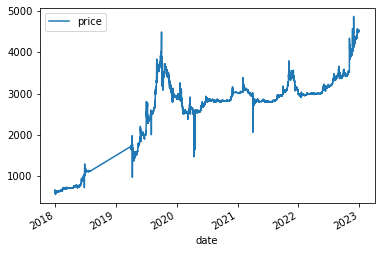

In [5]:
gold_df.plot()

#### 데이터 전처리

In [6]:
training_mean = gold_df.mean()
training_std = gold_df.std()
df_training_value = (gold_df - training_mean) / training_std  # z-score 정규화

# training_mean = cpu_load_normal_df.mean()
# training_std = cpu_load_normal_df.std()
# df_training_value = (cpu_load_normal_df - training_mean) / training_std  # z-score 정규화

#### Blocked CV 형식으로 데이터 분할

In [7]:
# Blocked Crossvalidation
TIME_STEPS = 24  # 24시간 => 1일

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

# AutoEncoder, x=y
x_train = create_sequences(df_training_value.values)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print("Training input shape: ", x_train.shape)

Training input shape:  (36882, 24, 1)


In [8]:
# Blocked Crossvalidation
TIME_STEPS = 720  # 720시간 => 30일

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

# AutoEncoder, x=y
x_train = create_sequences(df_training_value.values)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print("Training input shape: ", x_train.shape)

Training input shape:  (36186, 720, 1)


In [9]:
df_training_value.shape

(36906, 1)

In [10]:
x_train.shape

(36186, 720, 1)

In [11]:
# CNN 기반 모델
model = keras.Sequential(
    [                         # 720,                1
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])), # 288, 1
        # 요약한 정보를 32차원으로 바꾸고, 7개의 window를 보고, 3개 중에서 pooling을 하겠다.
        # MaxPooling, AveragePooling
        # Encoder 시작
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=3, activation="relu" # 240, 32
        ),
        layers.Dropout(rate=0.2),
        # 요약한 정보를 16차원으로 바꾸고, 7개의 window를 보고, 3개 중에서 pooling을 하겠다
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=3, activation="relu" # 80, 16
        ),
        layers.Conv1D(
            filters=8, kernel_size=7, padding="same", strides=2, activation="relu" # 40, 8
        ),
        layers.Conv1D(
              filters=4, kernel_size=7, padding="same", strides=2, activation="relu" # 20, 4 <= z vector / Encoder 끝.
          ),
        # Decoder 시작
        layers.Conv1DTranspose(
            filters=8, kernel_size=7, padding="same", strides=2, activation="relu" # 40, 8
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu" # 80, 16
        ),
        layers.Dropout(rate=0.2),
        # 32차원으로 7개의 윈도우를 봐서, stride=2이므로, 시계열이 2배로 확장.
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=3, activation="relu" # 240 32
        ),
          layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=3, activation="relu" # 720, 32
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"), # 720, 1, 원본 시계열.
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 240, 32)           256       
                                                                 
 dropout (Dropout)           (None, 240, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 80, 16)            3600      
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 8)             904       
                                                                 
 conv1d_3 (Conv1D)           (None, 20, 4)             228       
                                                                 
 conv1d_transpose (Conv1DTra  (None, 40, 8)            232       
 nspose)                                                         
                                                        

In [12]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128
)

Epoch 1/50
283/283 [==============================] - 9s 10ms/step - loss: 0.2422
Epoch 2/50
283/283 [==============================] - 3s 9ms/step - loss: 0.1178
Epoch 3/50
283/283 [==============================] - 2s 9ms/step - loss: 0.0759
Epoch 4/50
283/283 [==============================] - 2s 8ms/step - loss: 0.0519
Epoch 5/50
283/283 [==============================] - 3s 9ms/step - loss: 0.0372
Epoch 6/50
283/283 [==============================] - 2s 9ms/step - loss: 0.0288
Epoch 7/50
283/283 [==============================] - 2s 9ms/step - loss: 0.0229
Epoch 8/50
283/283 [==============================] - 3s 9ms/step - loss: 0.0186
Epoch 9/50
283/283 [==============================] - 3s 9ms/step - loss: 0.0153
Epoch 10/50
283/283 [==============================] - 2s 9ms/step - loss: 0.0123
Epoch 11/50
283/283 [==============================] - 3s 9ms/step - loss: 0.0102
Epoch 12/50
283/283 [==============================] - 3s 10ms/step - loss: 0.0082
Epoch 13/50
283/283 [==

In [13]:
x_train_pred = model.predict(x_train)

1131/1131 [==============================] - 3s 2ms/step


In [14]:
x_train_pred.shape

(36186, 720, 1)

#### 학습 데이터를 그대로 복원  => 복원된 데이터와 학습 데이터를 비교

#### 이상치 포함

1131/1131 [==============================] - 3s 3ms/step


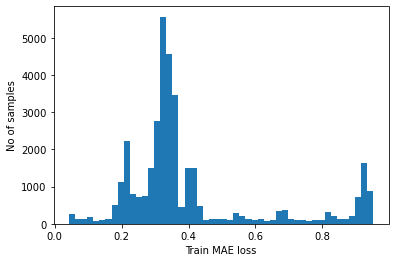

0.40516967892759254
0.2145284346798236
Reconstruction error threshold:  0.8342265482872397


In [15]:
x_train_pred = model.predict(x_train)
                          # 예측값 각각에 대한 mean absoulte err
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
# threshold = np.max(train_mae_loss) * 1 # 학습 데이터의 최대 에러의 95% 수준보다 넘어가는건 이상치다.
# threshold = np.max(train_mae_loss) * 1.2
mean = np.mean(train_mae_loss)
sigma = np.std(train_mae_loss)
print(mean)
print(sigma)
threshold = mean + (2*sigma)  # 정규분포일때 => 3시그마
# threshold = 0.3
print("Reconstruction error threshold: ", threshold)

#### 이상치 포함 X

In [16]:
anomalies = train_mae_loss > threshold # 학습 데이터의 최대 로스보다 큰 로스 값 index
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  3812
Indices of anomaly samples:  (array([   0,    1,    2, ..., 3809, 3811, 3813], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64))


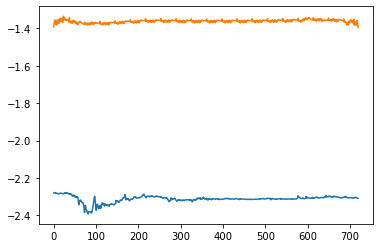

In [17]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [18]:
df_test_value = (gold_df - training_mean) / training_std

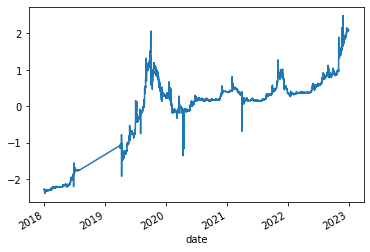

Test input shape:  (36186, 720, 1)
1131/1131 [==============================] - 2s 2ms/step


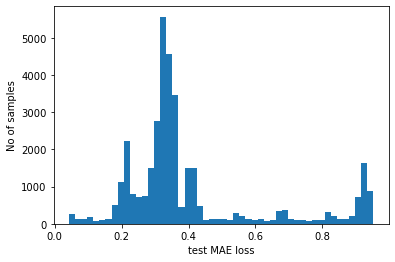

Number of anomaly samples:  3812
Indices of anomaly samples:  (array([   0,    1,    2, ..., 3809, 3811, 3813], dtype=int64),)


In [19]:
df_test_value = (gold_df - training_mean) / training_std

fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss_total = np.abs(x_test_pred - x_test)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold # 학습 데이터의 최대 로스보다 큰 로스 값 index
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [20]:
test_mae_loss_total

array([[[0.88809466],
        [0.91270636],
        [0.91311621],
        ...,
        [0.95143277],
        [0.92621117],
        [0.9134584 ]],

       [[0.88893531],
        [0.91128992],
        [0.91282772],
        ...,
        [0.95241385],
        [0.92605978],
        [0.91330343]],

       [[0.88726043],
        [0.91075706],
        [0.91117144],
        ...,
        [0.95239669],
        [0.92604237],
        [0.9098924 ]],

       ...,

       [[0.06061548],
        [0.08700413],
        [0.08264575],
        ...,
        [0.01322122],
        [0.00482087],
        [0.03320055]],

       [[0.06061703],
        [0.0813416 ],
        [0.05098133],
        ...,
        [0.01265426],
        [0.00527911],
        [0.03129011]],

       [[0.05184266],
        [0.04624633],
        [0.07700251],
        ...,
        [0.01223655],
        [0.00335008],
        [0.03379326]]])

In [21]:
len(df_test_value)

36906

In [22]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [23]:
anomalous_data_indices

[719,
 720,
 721,
 722,
 723,
 724,
 725,
 726,
 727,
 728,
 729,
 730,
 731,
 732,
 733,
 734,
 735,
 736,
 737,
 738,
 739,
 740,
 741,
 742,
 743,
 744,
 745,
 746,
 747,
 748,
 749,
 750,
 751,
 752,
 753,
 754,
 755,
 756,
 757,
 758,
 759,
 760,
 761,
 762,
 763,
 764,
 765,
 766,
 767,
 768,
 769,
 770,
 771,
 772,
 773,
 774,
 775,
 776,
 777,
 778,
 779,
 780,
 781,
 782,
 783,
 784,
 785,
 786,
 787,
 788,
 789,
 790,
 791,
 792,
 793,
 794,
 795,
 796,
 797,
 798,
 799,
 800,
 801,
 802,
 803,
 804,
 805,
 806,
 807,
 808,
 809,
 810,
 811,
 812,
 813,
 814,
 815,
 816,
 817,
 818,
 819,
 820,
 821,
 822,
 823,
 824,
 825,
 826,
 827,
 828,
 829,
 830,
 831,
 832,
 833,
 834,
 835,
 836,
 837,
 838,
 839,
 840,
 841,
 842,
 843,
 844,
 845,
 846,
 847,
 848,
 849,
 850,
 851,
 852,
 853,
 854,
 855,
 856,
 857,
 858,
 859,
 860,
 861,
 862,
 863,
 864,
 865,
 866,
 867,
 868,
 869,
 870,
 871,
 872,
 873,
 874,
 875,
 876,
 877,
 878,
 879,
 880,
 881,
 882,
 883,
 884,
 885

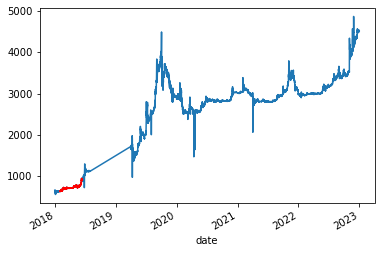

In [24]:
df_subset = gold_df.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
# plt.figure(figsize=(6,8))
gold_df.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()